<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1">Dependencies</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span></li><li><span><a href="#Paths" data-toc-modified-id="Paths-3">Paths</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-4">Main</a></span></li><li><span><a href="#Get-nonsyn-variants" data-toc-modified-id="Get-nonsyn-variants-5">Get nonsyn variants</a></span><ul class="toc-item"><li><span><a href="#CBTN" data-toc-modified-id="CBTN-5.1">CBTN</a></span></li><li><span><a href="#ICGC" data-toc-modified-id="ICGC-5.2">ICGC</a></span></li><li><span><a href="#TARGET" data-toc-modified-id="TARGET-5.3">TARGET</a></span></li><li><span><a href="#all-nonsyn-mutated-genes" data-toc-modified-id="all-nonsyn-mutated-genes-5.4">all nonsyn mutated genes</a></span></li></ul></li><li><span><a href="#Arriba" data-toc-modified-id="Arriba-6">Arriba</a></span></li><li><span><a href="#Oncoprint-known-alterations" data-toc-modified-id="Oncoprint-known-alterations-7">Oncoprint known alterations</a></span></li><li><span><a href="#Mutated-genes-in-oncogenic-pathways" data-toc-modified-id="Mutated-genes-in-oncogenic-pathways-8">Mutated genes in oncogenic pathways</a></span><ul class="toc-item"><li><span><a href="#Find-samples-with-at-least-one-alteration-in-genes-of-a-pathway" data-toc-modified-id="Find-samples-with-at-least-one-alteration-in-genes-of-a-pathway-8.1">Find samples with at least one alteration in genes of a pathway</a></span></li></ul></li><li><span><a href="#Mutations-in-immune-evasion-genes" data-toc-modified-id="Mutations-in-immune-evasion-genes-9">Mutations in immune evasion genes</a></span></li><li><span><a href="#Deprecated" data-toc-modified-id="Deprecated-10">Deprecated</a></span></li></ul></div>

# Dependencies

In [1]:
options(scipen = 999)

In [2]:
library(dplyr)
library(maftools)
library(rms)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve


Warning message in .recacheSubclasses(def@className, def, env):
“undefined subclass "numericVector" of class "Mnumeric"; definition not updated”


# Functions


In [3]:
source("~/OneDrive - UHN/R_src/ggplot2_theme.R")
source("~/OneDrive - UHN/R_src/color_schemes.R")
source("~/OneDrive - UHN/R_src/Heatmap_functions.R")
source("~/OneDrive - UHN/R_src/Oncoprint_functions.R")

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.12
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




In [4]:
pathway_heatmaps.fx <- function(df_K_allSNVs, gene_matrix, pathway, width){
    
    mypathway <- pathway[pathway %in% colnames(gene_matrix)]   
    pathway_matrix <- matrix(ncol = length(mypathway), nrow = 4, 
                             dimnames = list(c("C1", "C2", "C3", "C4"), mypathway))
    
    for(i in 1:ncol(pathway_matrix)){
    mygen <- colnames(pathway_matrix)[i]

    pathway_matrix[,i] <- table(df_K_allSNVs$immune_cluster, df_K_allSNVs[[mygen]])
}

    print(dim(pathway_matrix))
    
    rowha = rowAnnotation(`mutations/sample` = anno_barplot(as.vector(rowSums(pathway_matrix)/table(df_K_allSNVs$immune_cluster)),
                                                            border = FALSE), 
                           gp = gpar(col = "white", fill = "#4d4d4d" ), 
                           width = unit(4, "cm"))
    
    topha = HeatmapAnnotation(mutation = anno_barplot(colSums(pathway_matrix), border = FALSE), 
                              gp = gpar(col = "white", fill = "#4d4d4d" ), show_annotation_name = FALSE,
                              height = unit(2, "cm"))
    
    heatmap_order <- names(colSums(pathway_matrix))[order(colSums(pathway_matrix), decreasing = TRUE)]


    col_fun = colorRamp2(c(-1.5, 0, 1.5), c("blue", "white", "red"))
#print(summary(as.vector(scale(pathway_matrix))))
    K_pathways_hm = Heatmap(scale(pathway_matrix),
                      #titles and names
                      name = "Z-score counts",
                      show_heatmap_legend = FALSE,   
                      col = col_fun,      
                      column_title = deparse(substitute(pathway)),
                      show_row_names = TRUE,
                      show_column_names = TRUE,    
                      #clusters
                      cluster_columns = FALSE,
                      cluster_rows = FALSE,
                      #aesthestics
                      column_title_gp = gpar(fontsize = 20),
                      column_names_gp = gpar(fontsize = 8),
                      column_names_rot = 45,
                      height = unit(4, "cm"),
                      width = unit(width,"cm"),
                      row_names_gp = gpar(fontsize = 20),
                      row_names_side = "left",
                      #annotations
                      right_annotation = rowha,     
                      top_annotation = topha,
                      #order
                      column_order = heatmap_order)
    
      pdf(file = paste0(plotpath,"oncopathways_", deparse(substitute(pathway)), ".pdf"),
      width = 20, 
      height = 8,
      useDingbats = FALSE)
    draw(K_pathways_hm)
    dev.off()  
    
}

In [5]:
hla_heatmaps.fx <- function(df_K_allSNVs, HLA){
    
    HLA_matrix <- matrix(ncol = length(HLA), nrow = 4, 
                     dimnames = list(c("C1", "C2", "C3", "C4"), HLA))

for(i in 1:ncol(HLA_matrix)){
    mygen <- colnames(HLA_matrix)[i]
    HLA_matrix[,i] <- table(df_K_allSNVs$immune_cluster, df_K_allSNVs[[mygen]])
}    
    print(HLA_matrix)

    rowha = rowAnnotation(mutation = anno_barplot(rowSums(HLA_matrix), border = FALSE), 
                           gp = gpar(col = "white", fill = "#4d4d4d" ), 
                           width = unit(4, "cm"))
    
    topha = HeatmapAnnotation(mutation = anno_barplot(colSums(HLA_matrix), border = FALSE), 
                              gp = gpar(col = "white", fill = "#4d4d4d" ), 
                              height = unit(2, "cm"))
    
    heatmap_order <- names(colSums(HLA_matrix))[order(colSums(HLA_matrix), decreasing = TRUE)]
    
HLA_hm = Heatmap(scale(HLA_matrix),
                        #titles and names
                      name = "Z-score count",
                      column_title = deparse(substitute(HLA)),
                      show_row_names = TRUE,
                      show_column_names = TRUE,    
                      #clusters
                      cluster_columns = FALSE,
                      cluster_rows = FALSE,
                      #aesthestics
                      column_title_gp = gpar(fontsize = 40),
                      column_names_gp = gpar(fontsize = 8),
                      column_names_rot = 45,
                      height = unit(4, "cm"),
                      #width = unit(15,"cm"),
                      row_names_gp = gpar(fontsize = 20),
                      row_names_side = "left",
                      #annotations
                      right_annotation = rowha,     
                      top_annotation = topha,
                      #order
                      column_order = heatmap_order)
    
      pdf(file = paste0(plotpath,"HLAgenes_", deparse(substitute(HLA)), ".pdf"),
      width = 10, height = 5,useDingbats = FALSE)
    print(HLA_hm)
    dev.off()  
    
}

# Paths

In [6]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Plots/"

# Main

Load df with matched TMB and estimate

In [7]:
load(file = paste0(datapath,"snv/total_mut_manifest_estimate.RData"))

In [8]:
load(file = file.path(datapath,"TME_clusters/IPD_estimate_metadata_IC.RData"))

In [9]:
ped_tmb <- total_mut_manifest_estimate[ total_mut_manifest_estimate$group != "TCGA",]

Add a new variable percentage reads for total_mut_manifest_estimate_quanti

In [10]:
ped_tmb$percread <- 8.0947988*exp(ped_tmb$ImmuneScore*0.0006267)

In [11]:
ped_tmb_IC <- merge(ped_tmb, metadata_IC[,c("sample_id", "immune_cluster", "tumour_subtype")], by = "sample_id")

In [12]:
dim(ped_tmb_IC)

[1] 763  35

# Get nonsyn variants

## CBTN

add variantfilenames to oncokb-annotated combined_maf

In [13]:
CBTN_mafsummary <- read.table(file = paste0(datapath, "snv/CBTTC_mafsummary_overlapped_3VAF.txt"),
                              sep = "\t", check.names = F, header = TRUE, stringsAsFactors = FALSE)

In [14]:
dim(CBTN_mafsummary)

[1] 796  10

In [15]:
mymaf_CBTN <- read.maf(maf =  paste0(datapath, "snv/CBTTC_maf_overlapped_3VAF.maf"),
                      useAll = TRUE, verbose = FALSE,
                      vc_nonSyn = c("Frame_Shift_Del", "Frame_Shift_Ins", 
                                    "Nonsense_Mutation","Nonstop_Mutation", 
                                    "In_Frame_Del","In_Frame_Ins", "Missense_Mutation"))

In [16]:
mymaf_CBTN@summary

ID,summary,Mean,Median
<chr>,<chr>,<dbl>,<dbl>
NCBI_Build,GRCh38,NA,NA
Center,Mutect2,NA,NA
Samples,842,NA,NA
nGenes,13511,NA,NA
Frame_Shift_Del,845,1.004,0
Frame_Shift_Ins,769,0.913,0
In_Frame_Del,160,0.190,0
In_Frame_Ins,30,0.036,0
Missense_Mutation,50771,60.298,4


In [17]:
CBTN_data_maf <- mymaf_CBTN@data

In [18]:
head(CBTN_data_maf[,20:30])

Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method
<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
A,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
T,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


calculate tumour VAF

In [19]:
CBTN_data_maf$t_VAF <- CBTN_data_maf$t_alt_count / CBTN_data_maf$t_depth

In [20]:
summary(CBTN_data_maf$t_VAF)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03125 0.23913 0.32468 0.31363 0.39216 1.00000 

In [21]:
CBTN_data_maf$Tumor_Sample_Barcode <- as.character(CBTN_data_maf$Tumor_Sample_Barcode)

In [22]:
table(CBTN_data_maf$Variant_Classification)


  Frame_Shift_Del   Frame_Shift_Ins      In_Frame_Del      In_Frame_Ins 
              845               769               160                30 
Missense_Mutation Nonsense_Mutation  Nonstop_Mutation 
            50771              2840                25 

In [23]:
CBTN_data_maf_sampleid <- merge(CBTN_mafsummary[,c("sample_id", "Tumor_Sample_Barcode")], CBTN_data_maf, by = "Tumor_Sample_Barcode")

In [24]:
length(unique(CBTN_data_maf_sampleid$Tumor_Sample_Barcode))

[1] 796

Subset  snv dfs to include only samples in estimate df

In [25]:
CBTN_data_maf <- CBTN_data_maf_sampleid[CBTN_data_maf_sampleid$sample_id %in% ped_tmb_IC$sample_id,]

In [26]:
length(unique(CBTN_data_maf$Tumor_Sample_Barcode))

[1] 470

In [27]:
CBTN_data_maf_kb <- CBTN_data_maf[grepl("oncogenic", CBTN_data_maf$oncogenic,ignore.case = T),]

## ICGC

In [28]:
ICGC_maf <- read.table(file = paste0(datapath, "snv/dkfz_mafKB.maf"),sep = "\t", check.names = F,
                       header = TRUE, comment.char = "",stringsAsFactors = FALSE)

In [29]:
table(ICGC_maf$variant_classification)


    frameshift deletion    frameshift insertion  nonframeshift deletion 
                    600                     330                     150 
nonframeshift insertion       nonsynonymous SNV                splicing 
                     42                   18871                      59 
               stopgain            stopgain SNV            stoploss SNV 
                     16                    1222                       4 
         synonymous SNV 
                    424 

In [30]:
ICGC_maf_nsyn <- ICGC_maf[!ICGC_maf$variant_classification %in% c("splicing", "synonymous SNV"),]

In [31]:
colnames(ICGC_maf_nsyn)[colnames(ICGC_maf_nsyn) == "Tumor_Sample_Barcode"] <- "sample_id"

In [32]:
dim(ICGC_maf)
dim(ICGC_maf_nsyn)

[1] 21718    17

[1] 21235    17

In [33]:
colnames(ICGC_maf)[colnames(ICGC_maf) == "Tumor_Sample_Barcode"] <- "sample_id"

In [34]:
ICGC_maf_kb <- ICGC_maf[grepl("oncogenic", ICGC_maf$oncogenic, ignore.case = T),]

In [35]:
dim(ICGC_maf)
dim(ICGC_maf_kb)

[1] 21718    17

[1] 481  17

## TARGET

In [36]:
mymaf_gdc <- read.maf(maf =  paste0(datapath, "snv/GDC_allmaf_3VAF_fl_dedup_sampleid_KB.maf"),useAll = TRUE, verbose = FALSE,
                      vc_nonSyn = c("Frame_Shift_Del", "Frame_Shift_Ins", "Nonsense_Mutation","Nonstop_Mutation", 
                                    "In_Frame_Del","In_Frame_Ins", "Missense_Mutation"))

In [37]:
mymaf_gdc_data<- mymaf_gdc@data

In [38]:
length(unique(mymaf_gdc_data$Tumor_Sample_Barcode))

[1] 2749

In [39]:
mymaf_gdc_data$Tumor_Sample_Barcode <- as.character(mymaf_gdc_data$Tumor_Sample_Barcode)

In [40]:
table(mymaf_gdc_data$Variant_Classification)


  Frame_Shift_Del   Frame_Shift_Ins      In_Frame_Del      In_Frame_Ins 
            17243             10161              1306              1752 
Missense_Mutation Nonsense_Mutation  Nonstop_Mutation 
           288342             21973               264 

subset to TARGET data and match with total_mut_manifest_estimate_quanti

In [41]:
mymaf_target_data <- mymaf_gdc_data[grepl("TARGET", mymaf_gdc_data$Tumor_Sample_Barcode),]

In [42]:
length(unique(mymaf_target_data$Tumor_Sample_Barcode))

[1] 131

In [43]:
mymaf_target_data <- mymaf_target_data[mymaf_target_data$Tumor_Sample_Barcode %in% ped_tmb_IC$sample_id,]

In [44]:
colnames(mymaf_target_data)[colnames(mymaf_target_data) == "Tumor_Sample_Barcode"] <- "sample_id"

In [45]:
mymaf_target_data_kb <- mymaf_target_data[grepl("oncogenic", mymaf_target_data$oncogenic,ignore.case = T),]

In [46]:
colnames(mymaf_target_data_kb)[colnames(mymaf_target_data_kb) == "Tumor_Sample_Barcode"] <- "sample_id"

In [47]:
dim(mymaf_target_data)
dim(mymaf_target_data_kb)

[1] 1888  156

[1]  19 156

In [48]:
dim(CBTN_data_maf)
dim(CBTN_data_maf_kb)

[1] 20087   163

[1] 324 163

## all nonsyn mutated genes

In [49]:
icgc_allmut <- as.data.frame(table(ICGC_maf_nsyn$Hugo_Symbol), stringsAsFactors = F)
cbtn_allmut <- as.data.frame(table(CBTN_data_maf$Hugo_Symbol), stringsAsFactors = F)
target_allmut <- as.data.frame(table(mymaf_target_data$Hugo_Symbol), stringsAsFactors = F)

In [50]:
mutated_genes_all <- c(icgc_allmut$Var1, cbtn_allmut$Var1, target_allmut$Var1)

In [51]:
allmutated_genes <- mutated_genes_all[!duplicated(mutated_genes_all)]

In [52]:
length(allmutated_genes)

[1] 12013

# Arriba

In [53]:
# from Arriba_dataframe notebook
load(paste0(datapath, "fusion/arriba_df_conf_ss.RData"))

In [54]:
dim(arriba_df_conf_ss)

[1] 6048   26

# Oncoprint known alterations 

In [55]:
known_alterations <- xlsx::read.xlsx(file = paste0(datapath, "snv/Known_mutations_Jones_Et_al_Nature_Review_ped_CNS_and_NBL_Oct2021.xlsx"),
                                    sheetIndex = 1)

Bind all

In [56]:
colnames(ICGC_maf_nsyn)[colnames(ICGC_maf_nsyn) == "variant_classification"] <- "Variant_Classification"

In [57]:
ped_snv_data <- rbind(CBTN_data_maf[,c("sample_id", "Hugo_Symbol","Variant_Classification")],
                     mymaf_target_data[,c("sample_id", "Hugo_Symbol", "Variant_Classification")],
                     ICGC_maf_nsyn[,c("sample_id", "Hugo_Symbol", "Variant_Classification")])

In [58]:
ped_snv_data$Variant_Classification <- as.character(ped_snv_data$Variant_Classification)

In [59]:
table(ped_snv_data$Variant_Classification)


        Frame_Shift_Del         Frame_Shift_Ins     frameshift deletion 
                    322                     419                     600 
   frameshift insertion            In_Frame_Del            In_Frame_Ins 
                    330                      58                      63 
      Missense_Mutation  nonframeshift deletion nonframeshift insertion 
                  19910                     150                      42 
      Nonsense_Mutation        Nonstop_Mutation       nonsynonymous SNV 
                   1191                      12                   18871 
               stopgain            stopgain SNV            stoploss SNV 
                     16                    1222                       4 

In [60]:
dim(ped_snv_data)

[1] 43210     3

In [61]:
table(ped_snv_data$Hugo_Symbol)


           A1BG            A1CF             A2M           A2ML1           A4GNT 
              1               3               4              10               1 
           AACS           AADAC         AADACL3         AADACL4           AADAT 
              2               2               2               9               1 
          AANAT            AAR2            AARS           AARS2           AASDH 
              3               6               2               2               2 
           AASS            AATK            ABAT           ABCA1          ABCA10 
              6               8              11              12               3 
         ABCA12          ABCA13           ABCA2           ABCA3           ABCA4 
             13              18              18               8              10 
          ABCA5           ABCA6           ABCA7           ABCA8           ABCA9 
              2               4               8               4               6 
          ABCB1          AB

add arriba df - count each gene only once to remove transcripts and different breakpoints

In [62]:
arriba_df_4oncoprint <- arriba_df_conf_ss[,c("sample_id", "gene1")]

arriba_df_4oncoprint1 <- arriba_df_conf_ss[,c("sample_id", "gene2")]

colnames(arriba_df_4oncoprint1) <- c("sample_id", "Hugo_Symbol")
colnames(arriba_df_4oncoprint) <- c("sample_id", "Hugo_Symbol")

arriba_df_4oncoprint <- rbind(arriba_df_4oncoprint, arriba_df_4oncoprint1)

arriba_df_4oncoprint <- arriba_df_4oncoprint[!duplicated(arriba_df_4oncoprint),]

In [63]:
arriba_df_4oncoprint <- arriba_df_4oncoprint[!grepl("),", arriba_df_4oncoprint$Hugo_Symbol),]

In [64]:
dim(arriba_df_4oncoprint)

[1] 5080    2

In [65]:
arriba_df_4oncoprint$Variant_Classification <- "fusion"

In [66]:
table(arriba_df_4oncoprint$Hugo_Symbol)


                AACSP1                 ABCA10                 ABCA13 
                     1                      1                      1 
                 ABCA6                  ABCA7                  ABCA9 
                     1                      1                      1 
                 ABCB1                  ABCB5                 ABCC11 
                     1                      1                      1 
                 ABHD8                   ABL1                    ABR 
                     1                      1                      3 
            AC002127.2             AC002127.4             AC002454.1 
                     1                      3                      2 
            AC004080.6             AC004160.1             AC004538.3 
                     1                      1                      1 
            AC004691.2             AC004805.1             AC004828.1 
                     1                      8                      5 
            AC00485

In [67]:
ped_snv_arriba <- rbind(ped_snv_data, arriba_df_4oncoprint)

In [68]:
# Subset to known alterations
ped_snv_arriba_known <- ped_snv_arriba[ ped_snv_arriba$Hugo_Symbol %in% 
                                    known_alterations$gene.name.to.use.in.R.python.scripts.or.grep.command,]

In [69]:
table(ped_snv_arriba_known$Variant_Classification)


        Frame_Shift_Del         Frame_Shift_Ins     frameshift deletion 
                     24                      10                      75 
   frameshift insertion                  fusion            In_Frame_Del 
                     15                     195                       2 
           In_Frame_Ins       Missense_Mutation  nonframeshift deletion 
                      8                     258                      34 
nonframeshift insertion       Nonsense_Mutation       nonsynonymous SNV 
                     14                      33                     462 
           stopgain SNV 
                     59 

In [70]:
dim(ped_snv_arriba_known)

[1] 1189    3

In [71]:
# recode for visualization
ped_snv_arriba_known$Variants <- NA

ped_snv_arriba_known$Variants[ grepl("Frame_Shift",ped_snv_arriba_known$Variant_Classification)] <- "Frameshift Ins/Del"
ped_snv_arriba_known$Variants[ grepl("frameshift",ped_snv_arriba_known$Variant_Classification)] <- "In frame Ins/Del"

ped_snv_arriba_known$Variants[ grepl("In_Frame",ped_snv_arriba_known$Variant_Classification)] <- "In frame Ins/Del"
ped_snv_arriba_known$Variants[ grepl("nonframeshift",ped_snv_arriba_known$Variant_Classification)] <- "In frame Ins/Del"

ped_snv_arriba_known$Variants[ grepl("Missense",ped_snv_arriba_known$Variant_Classification)] <- "Missense"
ped_snv_arriba_known$Variants[ grepl("nonsynonymous",ped_snv_arriba_known$Variant_Classification)] <- "Missense"

ped_snv_arriba_known$Variants[ grepl("Nonsense",ped_snv_arriba_known$Variant_Classification)] <- "Nonsense"
ped_snv_arriba_known$Variants[ grepl("stopgain",ped_snv_arriba_known$Variant_Classification)] <- "Nonsense"

ped_snv_arriba_known$Variants[ grepl("Nonstop_Mutation",ped_snv_arriba_known$Variant_Classification)] <- "Nonstop"
ped_snv_arriba_known$Variants[ grepl("stoploss",ped_snv_arriba_known$Variant_Classification)] <- "Nonstop"

ped_snv_arriba_known$Variants[ grepl("fusion",ped_snv_arriba_known$Variant_Classification)] <- "Fusion"

In [72]:
table(ped_snv_arriba_known$Variants, useNA = "always")


Frameshift Ins/Del             Fusion   In frame Ins/Del           Missense 
                34                195                148                720 
          Nonsense               <NA> 
                92                  0 

In [75]:
oncomat <- matrix(ncol = nrow(ped_tmb_IC), nrow = length(unique(ped_snv_arriba_known$Hugo_Symbol)))
colnames(oncomat) <- ped_tmb_IC$sample_id
rownames(oncomat) <- unique(ped_snv_arriba_known$Hugo_Symbol)

In [76]:
for(i in 1:ncol(oncomat)){
    mysampleid <- colnames(oncomat)[i]
    mygenes <- ped_snv_arriba_known[ped_snv_arriba_known$sample_id == mysampleid,]
    oncomat[,i] <- mygenes$Variants[match(rownames(oncomat),mygenes$Hugo_Symbol)]} 

In [77]:
oncomat <- oncomat[1:10,]

In [78]:
sums <- colSums(is.na(oncomat))

In [79]:
ped_tmb_IC$colsums <- sums[match(names(sums), ped_tmb_IC$sample_id)]

In [80]:
cluster_cohort <- ped_tmb_IC[order(ped_tmb_IC$immune_cluster, ped_tmb_IC$colsums),]

In [81]:
mycluster <- as.character(cluster_cohort$immune_cluster)
names(mycluster) <- cluster_cohort$sample_id
cluster_hm <- class_hm.fx(mycluster)

In [82]:
annotation_order <- c("Pediatric inflammed", "Myeloid-driven", "Pediatric cold", "Immune excluded")

In [83]:
cluster_ha = HeatmapAnnotation(clusters = anno_mark(at = c(36, 188, 472, 702), labels_rot = 0,
                                                    labels = annotation_order, side = "top",
                                                    labels_gp = gpar(fontsize = 40), 
                                                    link_height = unit(0.5, "cm")))

In [84]:
oncomat[is.na(oncomat)] <- ""

In [85]:
onco = oncoPrint(oncomat[,names(mycluster)],
                 alter_fun = alter_fun,
                 col = col, 
                 #column_order = cluster_cohort$sample_id,
                 show_heatmap_legend = FALSE,
                 show_column_names = FALSE,
                 row_names_gp = gpar(fontsize = 30),
                 remove_empty_rows = FALSE,
                 show_pct = FALSE, 
                 right_annotation = NULL, 
                 top_annotation = NULL) 

All mutation types: Frameshift Ins/Del, Missense, Fusion, In frame
Ins/Del, Nonsense.

`alter_fun` is assumed vectorizable. If it does not generate correct
plot, please set `alter_fun_is_vectorized = FALSE` in `oncoPrint()`.



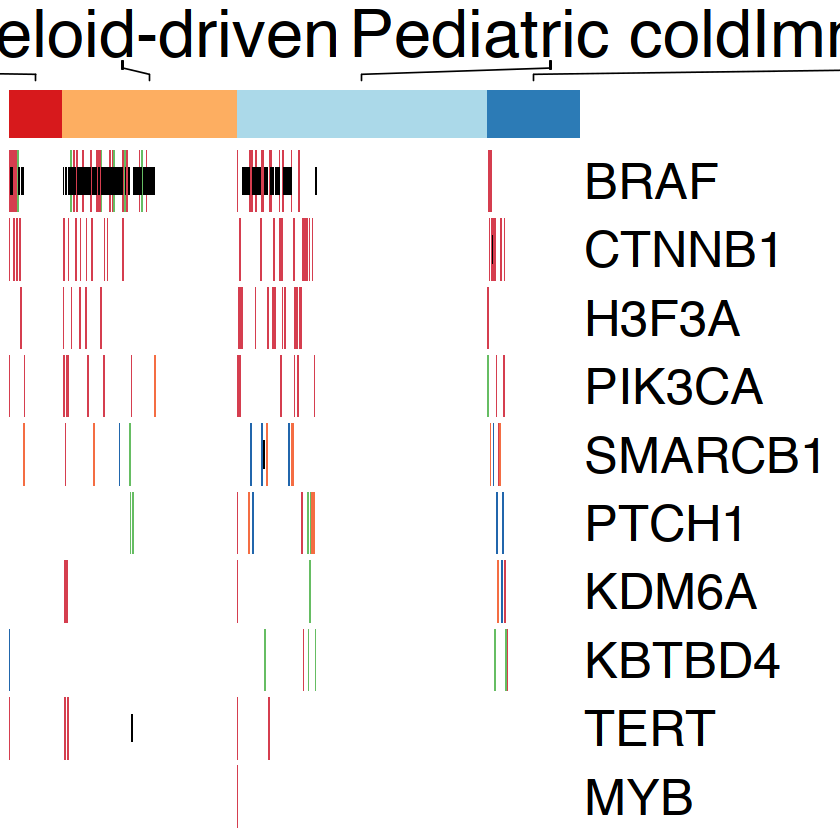

In [86]:
cluster_ha %v% cluster_hm %v% onco

In [88]:
  pdf(file = paste0(plotpath,"oncoprint_immuneclusters.pdf"),
      width = 40, 
      height = 10,
      useDingbats = FALSE)
  draw(cluster_ha %v% cluster_hm %v% onco, gap = unit(1,"cm"))
  dev.off()  

pdf 
  2

Legend

In [89]:
lgd = Legend(labels = names(col), title = "Alteration",
             legend_gp = gpar(fill = col))

In [90]:
  pdf(file = paste0(plotpath,"oncoprint_legend.pdf"),
      width = 8, 
      height = 8,
      useDingbats = FALSE)
  draw(lgd)
  dev.off()  

pdf 
  2

# Mutated genes in oncogenic pathways

Bind all SNVs and Fusions for pathway analysis

In [91]:
dim(ped_snv_arriba)

[1] 48290     3

In [92]:
table(ped_snv_arriba$Variant_Classification)


        Frame_Shift_Del         Frame_Shift_Ins     frameshift deletion 
                    322                     419                     600 
   frameshift insertion                  fusion            In_Frame_Del 
                    330                    5080                      58 
           In_Frame_Ins       Missense_Mutation  nonframeshift deletion 
                     63                   19910                     150 
nonframeshift insertion       Nonsense_Mutation        Nonstop_Mutation 
                     42                    1191                      12 
      nonsynonymous SNV                stopgain            stopgain SNV 
                  18871                      16                    1222 
           stoploss SNV 
                      4 

In [93]:
# recode for visualization
ped_snv_arriba$Variants <- NA

ped_snv_arriba$Variants[ grepl("Frame_Shift",ped_snv_arriba$Variant_Classification)] <- "Frameshift Ins/Del"
ped_snv_arriba$Variants[ grepl("In_Frame",ped_snv_arriba$Variant_Classification)] <- "In frame Ins/Del"

ped_snv_arriba$Variants[ grepl("Missense",ped_snv_arriba$Variant_Classification)] <- "Missense"
ped_snv_arriba$Variants[ grepl("nonsynonymous",ped_snv_arriba$Variant_Classification)] <- "Missense"

ped_snv_arriba$Variants[ grepl("Nonsense",ped_snv_arriba$Variant_Classification)] <- "Nonsense"
ped_snv_arriba$Variants[ grepl("stopgain",ped_snv_arriba$Variant_Classification)] <- "Nonsense"

ped_snv_arriba$Variants[ grepl("Nonstop_Mutation",ped_snv_arriba$Variant_Classification)] <- "Nonstop"
ped_snv_arriba$Variants[ grepl("stoploss",ped_snv_arriba$Variant_Classification)] <- "Nonstop"

ped_snv_arriba$Variants[ grepl("fusion",ped_snv_arriba$Variant_Classification)] <- "Fusion"

In [94]:
tail(ped_snv_arriba)

,sample_id,Hugo_Symbol,Variant_Classification,Variants
,<chr>,<chr>,<chr>,<chr>
482691,ICGC_PA91,BRAF,fusion,Fusion
482791,ICGC_PA91,TAX1BP1,fusion,Fusion
483431,ICGC_PA93,BRAF,fusion,Fusion
484011,ICGC_PA95,BRAF,fusion,Fusion
484181,ICGC_PA96,BRAF,fusion,Fusion
484421,ICGC_PA97,BRAF,fusion,Fusion


Based on TCGA oncogenic pathways. DNArepair pathway is self-made

In [95]:
mygenes <- read.csv(paste0(datapath, "mygenes.csv"), header = F, stringsAsFactors = F)

In [96]:
rownames(mygenes) <- mygenes$V1
mygenes$V1 <- NULL

In [97]:
dnarepair <- mygenes["dnarepair",]
rtk <- mygenes["rtk",]
pi3k <- mygenes["pi3k",]
wnt <- mygenes["wnt",]
cellcycle <- mygenes["cellcycle",]
notch <- mygenes["notch",]
mmr <- c("PMS2", "POLE", "POLD1", "MSH6", "MSH2", "MLH2")

In [98]:
notch <- unlist(notch)[unlist(notch) != ""]
dnarepair <- unlist(dnarepair)[unlist(dnarepair) != ""]
rtk <- unlist(rtk)[unlist(rtk) != ""]
pi3k <- unlist(pi3k)[unlist(pi3k) != ""]
wnt <- unlist(wnt)[unlist(wnt) != ""]
cellcycle <- unlist(cellcycle)[unlist(cellcycle) != ""]

In [99]:
genmat <- matrix(nrow = nrow(ped_tmb_IC), 
                 ncol = length(unique(ped_snv_arriba$Hugo_Symbol)))

rownames(genmat) <- ped_tmb_IC$sample_id
colnames(genmat) <- unique(ped_snv_arriba$Hugo_Symbol)

for(i in 1:nrow(genmat)){
    mysampleid <- rownames(genmat)[i]
    mygenes <- ped_snv_arriba[ped_snv_arriba$sample_id == mysampleid,]
    genmat[i,] <- mygenes$Variants[match(colnames(genmat),mygenes$Hugo_Symbol)]
    }    
    
    print(dim(genmat))

genmat[!is.na(genmat)] <- 1

[1]   763 13075


In [100]:
genmat <- genmat[,colSums(is.na(genmat)) < 763]

In [101]:
dim(genmat)

[1]   763 12874

In [102]:
#bind to metadata
ped_tmb_IC_allSNVs <- cbind(ped_tmb_IC, genmat)

In [103]:
class(genmat) <- "numeric"

## Find samples with at least one alteration in genes of a pathway

In [113]:
ped_tmb_IC_pathway <- ped_tmb_IC

In [114]:
for( i in c("wnt", "notch", "rtk", "pi3k", "cellcycle", "mmr")){
   genmat_pathway <- genmat[,colnames(genmat)[colnames(genmat) %in% eval(as.name(i))]] 
   mut_sum <- rowSums(genmat_pathway, na.rm = T)
   mut_sum[mut_sum > 0] <- 1 
    # append number of genes in each pathway to the colname
    pathway_name <- paste0(i, "_", ncol(genmat_pathway))
   ped_tmb_IC_pathway[[pathway_name]] <- mut_sum
    
}

In [115]:
ped_tmb_IC_pathway

sample_id,aliquot_id,StromalScore,ImmuneScore,ESTIMATEScore,name,case_id,gender,ethnicity,race,⋯,percread,immune_cluster,tumour_subtype,colsums,wnt_48,notch_50,rtk_71,pi3k_26,cellcycle_10,mmr_5
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7316-10,717108,948.22241,1027.24522,1975.467631,cae75655-bec6-4ab6-af6f-e286f4cae404.rsem.genes.results,C15129,Female,Not Hispanic or Latino,African,⋯,15.409687,Myeloid-driven,NA,10,0,0,0,0,0,0
7316-101,588338,-844.57906,-289.52536,-1134.104420,f52e9f4d-6f98-41e6-872f-107137f59980.rsem.genes.results,C23862,Male,Not Hispanic or Latino,African,⋯,6.751578,Immune excluded,BRAF_WT,10,0,0,0,0,0,0
7316-1075,588351,-186.46944,669.72615,483.256707,f1ea5df0-95b3-436a-9168-036e482cb76f.rsem.genes.results,C291264,Male,Reported Unknown,Other,⋯,12.316491,Myeloid-driven,NA,9,1,0,0,0,0,0
7316-1077,731885,-680.64842,-475.48821,-1156.136637,5a8eb07f-4d9b-437f-a44b-432e5dc6b1f8.rsem.genes.results,C291510,Male,Reported Unknown,Other,⋯,6.008849,Pediatric cold,BRAF_WT,10,0,0,1,0,0,0
7316-1078,588352,-823.48088,-630.51067,-1453.991547,b38b70ba-1b14-49a8-9386-007bcb0ef2aa.rsem.genes.results,C291633,Male,Reported Unknown,Other,⋯,5.452535,Pediatric cold,EPN_Fossa,10,0,0,0,0,0,0
7316-1081,731897,-413.66408,879.16746,465.503384,1da1eb0c-f54d-4bce-8f02-55899fc8761f.rsem.genes.results,C410697,Male,Reported Unknown,Other,⋯,14.044010,Myeloid-driven,BRAF_KIAA1549,9,0,0,1,0,0,0
7316-1082,728285,1943.13080,2326.18790,4269.318697,f22d1fdf-64c6-456c-89e4-95a741ae455e.rsem.genes.results,C409467,Female,Reported Unknown,Other,⋯,34.780041,Pediatric inflamed,NA,10,0,0,0,0,0,0
7316-1083,588302,-1676.42096,-1917.15688,-3593.577841,2f9ae1ba-fa5d-43f0-8ffb-4dc01fd80ec6.rsem.genes.results,C409836,Male,Reported Unknown,Other,⋯,2.434495,Immune excluded,MB_GR34,10,0,0,0,0,0,0
7316-1084,731871,633.42795,1509.31163,2142.739585,c8554fc6-c569-4056-a92c-358a9a6ec4a0.rsem.genes.results,C409959,Female,Reported Unknown,Other,⋯,20.844859,Pediatric inflamed,BRAF_p.V600E,9,0,0,1,0,0,0


In [116]:
pathway_mat <- matrix(nrow = 4, ncol = 6)

rownames(pathway_mat) <- c("Pediatric inflamed", "Myeloid-driven", "Pediatric cold", "Immune excluded")
colnames(pathway_mat) <- c("wnt_48", "notch_50", "rtk_71", "pi3k_26", "cellcycle_10", "mmr_5")

for(k in 1:nrow(pathway_mat)){
    mycluster <- rownames(pathway_mat)[k]
    tmp <- ped_tmb_IC_pathway[ ped_tmb_IC_pathway$immune_cluster == mycluster,]
    for(p in 1:ncol(pathway_mat)){
        mypathway <- colnames(pathway_mat)[p]
     freqtab <- as.data.frame(table(tmp[[mypathway]]), stringsAsFactors = F)
     freqtab$perc <- freqtab$Freq/sum(freqtab$Freq)   
    pathway_mat[k,p] <- freqtab$perc[2]
    }}    


In [117]:
# cleanup pathway labels
col_labels = structure(c("Wnt (48)", "Notch (50)", "RTK (71)", "PI3K (26)", "Cell cycle (10)", "MMR (5)"),
                       names = colnames(pathway_mat))

In [118]:
col_labels

wnt_48          notch_50            rtk_71           pi3k_26 
       "Wnt (48)"      "Notch (50)"        "RTK (71)"       "PI3K (26)" 
     cellcycle_10             mmr_5 
"Cell cycle (10)"         "MMR (5)"

In [119]:
pathway_mat

,wnt_48,notch_50,rtk_71,pi3k_26,cellcycle_10,mmr_5
Pediatric inflamed,0.09722222,0.04166667,0.2361111,0.04166667,0.013888889,0.027777778
Myeloid-driven,0.08583691,0.07296137,0.5793991,0.07296137,0.021459227,0.017167382
Pediatric cold,0.09552239,0.08955224,0.3104478,0.13432836,0.026865672,0.002985075
Immune excluded,0.08130081,0.09756098,0.1382114,0.07317073,0.008130081,0.008130081


In [120]:
col_fun = colorRamp2(c(-2,0, 2), c("blue", "white", "red"))

my_hm = Heatmap(scale(pathway_mat),
                      #titles and names
                      name = "% mutated",
                      show_heatmap_legend = FALSE,   
                      #col = col_fun, 
                      show_row_names = TRUE,
                      show_column_names = TRUE,    
                      #clusters
                      cluster_columns = TRUE,
                      cluster_rows = FALSE,
                      #aesthestics
                      column_title_gp = gpar(fontsize = 20),
                      column_names_gp = gpar(fontsize = 15),
                      column_names_rot = 45,
                      height = unit(4, "cm"),
                      width = unit(6,"cm"),
                      row_names_gp = gpar(fontsize = 15),
                      row_names_side = "left", column_labels = col_labels
)
    

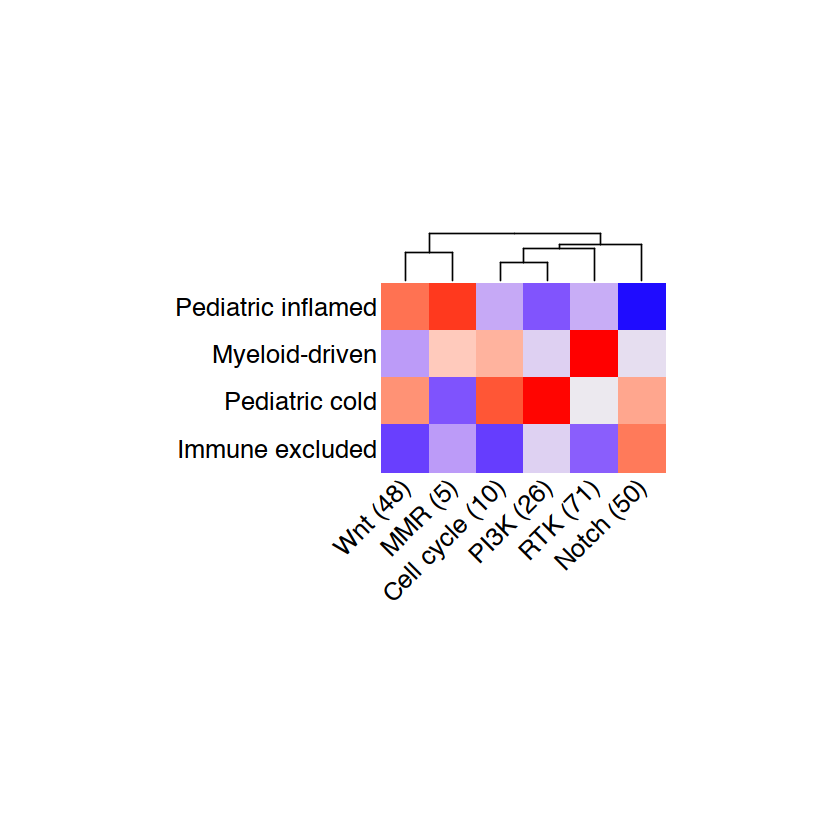

In [121]:
my_hm

In [122]:
pdf(file = paste0(plotpath,"oncogenic_pathways_IC.pdf"),
      width = 12, 
      height = 10,
      useDingbats = FALSE)
  draw(my_hm)
  dev.off() 

pdf 
  2

In [123]:
col_fun = colorRamp2(c(-2,0, 2), c("blue", "white", "red"))
pathway_lgd = Legend(col_fun = col_fun, title = "Mutated samples\n(z-score)")

In [124]:
pdf(file = paste0(plotpath,"pathways_legend.pdf"),
      width = 8, 
      height = 8,
      useDingbats = FALSE)
  draw(pathway_lgd)
  dev.off()  

pdf 
  2

In [125]:
mantelhaen.test(x = ped_tmb_IC_pathway$mmr_5,y = ped_tmb_IC_pathway$immune_cluster, ped_tmb_IC_pathway$cohort)


	Cochran-Mantel-Haenszel test

data:  ped_tmb_IC_pathway$mmr_5 and ped_tmb_IC_pathway$immune_cluster and ped_tmb_IC_pathway$cohort
Cochran-Mantel-Haenszel M^2 = 4.5049, df = 3, p-value = 0.2119


In [127]:
mantelhaen.test(x = ped_tmb_IC_pathway$rtk_71,y = ped_tmb_IC_pathway$immune_cluster, ped_tmb_IC_pathway$cohort)


	Cochran-Mantel-Haenszel test

data:  ped_tmb_IC_pathway$rtk_71 and ped_tmb_IC_pathway$immune_cluster and ped_tmb_IC_pathway$cohort
Cochran-Mantel-Haenszel M^2 = 21.483, df = 3, p-value = 0.00008355


In [128]:
mantelhaen.test(x = ped_tmb_IC_pathway$wnt_48,y = ped_tmb_IC_pathway$immune_cluster, ped_tmb_IC_pathway$cohort)


	Cochran-Mantel-Haenszel test

data:  ped_tmb_IC_pathway$wnt_48 and ped_tmb_IC_pathway$immune_cluster and ped_tmb_IC_pathway$cohort
Cochran-Mantel-Haenszel M^2 = 2.4302, df = 3, p-value = 0.488


In [129]:
mantelhaen.test(x = ped_tmb_IC_pathway$notch_50,y = ped_tmb_IC_pathway$immune_cluster, ped_tmb_IC_pathway$cohort)


	Cochran-Mantel-Haenszel test

data:  ped_tmb_IC_pathway$notch_50 and ped_tmb_IC_pathway$immune_cluster and ped_tmb_IC_pathway$cohort
Cochran-Mantel-Haenszel M^2 = 2.0966, df = 3, p-value = 0.5526


In [130]:
mantelhaen.test(x = ped_tmb_IC_pathway$cellcycle_10,y = ped_tmb_IC_pathway$immune_cluster, ped_tmb_IC_pathway$cohort)


	Cochran-Mantel-Haenszel test

data:  ped_tmb_IC_pathway$cellcycle_10 and ped_tmb_IC_pathway$immune_cluster and ped_tmb_IC_pathway$cohort
Cochran-Mantel-Haenszel M^2 = 2.237, df = 3, p-value = 0.5247


In [131]:
mantelhaen.test(x = ped_tmb_IC_pathway$pi3k_26,y = ped_tmb_IC_pathway$immune_cluster, ped_tmb_IC_pathway$cohort)


	Cochran-Mantel-Haenszel test

data:  ped_tmb_IC_pathway$pi3k_26 and ped_tmb_IC_pathway$immune_cluster and ped_tmb_IC_pathway$cohort
Cochran-Mantel-Haenszel M^2 = 3.7114, df = 3, p-value = 0.2944


# Mutations in immune evasion genes

In [123]:
hlas <- allmutated_genes[grepl("HLA", allmutated_genes)]

In [124]:
allmutated_genes[grepl("TAP", allmutated_genes)]

[1] "KRTAP1-5"  "KRTAP10-1" "KRTAP10-5" "KRTAP10-7" "KRTAP10-9" "KRTAP12-4"
 [7] "KRTAP13-2" "KRTAP16-1" "KRTAP25-1" "KRTAP4-1"  "KRTAP4-3"  "KRTAP4-4" 
[13] "KRTAP4-5"  "KRTAP4-8"  "KRTAP5-5"  "KRTAP9-1"  "METAP1"    "TAP2"     
[19] "CRTAP"     "KRTAP1-1"  "KRTAP10-8" "KRTAP13-1" "KRTAP19-1" "KRTAP19-5"
[25] "KRTAP5-11" "KRTAP5-2"  "KRTAP5-9"  "METAP1D"   "METAP2"    "MTAP"     
[31] "STAP2"     "TAPBP"     "TAPBPL"    "WTAP"      "KRTAP19-4" "KRTAP20-1"

In [125]:
hlas

[1] "HHLA3"    "HLA-A"    "HLA-B"    "HLA-C"    "HLA-DQA1" "HLA-DQA2"
 [7] "HLA-DQB1" "HLA-DQB2" "HLA-DRB1" "HLA-DRB5" "HLA-E"    "HHLA2"

In [126]:
hlas <- hlas[ !hlas %in% c("HHLA2", "HHLA3")]

In [127]:
HLA_classI <- c("HLA-A", "HLA-B", "HLA-C", "HLA-E")
HLA_classII <- c("HLA-DQA1", "HLA-DQA2", "HLA-DQB1", "HLA-DQB2", "HLA-DRB1", "HLA-DRB5")

In [128]:
hla_heatmaps.fx(ped_tmb_IC_allSNVs, HLA_classI)
hla_heatmaps.fx(ped_tmb_IC_allSNVs, HLA_classII)

   HLA-A HLA-B HLA-C HLA-E
C1     0     0     1     0
C2     2     1     1     1
C3     0     2     0     0
C4     0     0     1     0


pdf 
  2

   HLA-DQA1 HLA-DQA2 HLA-DQB1 HLA-DQB2 HLA-DRB1 HLA-DRB5
C1        0        0        0        0        0        0
C2        1        2        0        0        1        0
C3        4        0        5        0        2        1
C4        1        0        0        1        0        0


pdf 
  2

# Deprecated

In [269]:
tmp <- ped_tmb_IC_allSNVs

In [270]:
tmp$TP53[is.na(tmp$TP53)] <- 0

In [274]:
lrm(TP53 ~ immune_cluster + cohort, data = tmp)

Logistic Regression Model
 
 lrm(formula = TP53 ~ immune_cluster + cohort, data = tmp)
 
                        Model Likelihood    Discrimination    Rank Discrim.    
                              Ratio Test           Indexes          Indexes    
 Obs           763    LR chi2     137.54    R2       0.457    C       0.894    
  0            718    d.f.            14    g        3.114    Dxy     0.789    
  1             45    Pr(> chi2) <0.0001    gr      22.507    gamma   0.823    
 max |deriv| 0.001                          gp       0.090    tau-a   0.088    
                                            Brier    0.037                     
 
                   Coef    S.E.     Wald Z Pr(>|Z|)
 Intercept         -2.7981   1.1348 -2.47  0.0137  
 immune_cluster=C2 -0.7210   0.8208 -0.88  0.3797  
 immune_cluster=C3 -0.7021   0.7780 -0.90  0.3669  
 immune_cluster=C4 -0.8208   0.8710 -0.94  0.3460  
 cohort=CP         -7.8362  81.1837 -0.10  0.9231  
 cohort=CPH        -8.1523  66.5636 -

In [272]:
mantelhaen.test(x = tmp$TP53,y = tmp$immune_cluster, tmp$cohort)


	Cochran-Mantel-Haenszel test

data:  tmp$TP53 and tmp$immune_cluster and tmp$cohort
Cochran-Mantel-Haenszel M^2 = 0.99725, df = 3, p-value = 0.8019


In [ ]:
heatmap_top10_genes <- function(tmb_df_ic, snv_data, immuneK, fontsize, mytitle, showlegend){
    
    IC_ped <- tmb_df_ic[tmb_df_ic$immune_cluster == immuneK,]    
  
    mutmat <- matrix(ncol = nrow(IC_ped), nrow = length(unique(snv_data$Hugo_Symbol)))
    colnames(mutmat) <- IC_ped$sample_id
    rownames(mutmat) <- unique(snv_data$Hugo_Symbol)

  for(i in 1:ncol(mutmat)){
    mysampleid <- colnames(mutmat)[i]
    mygenes <- snv_data[snv_data$sample_id == mysampleid,]
    mutmat[,i] <- mygenes$Variants[match(rownames(mutmat),mygenes$Hugo_Symbol)]
  } 
     genefreq <- rowSums(!is.na(mutmat))
    

  topX <- genefreq[order(genefreq, decreasing = T)][1:10]
  mutmat <- mutmat[names(topX), ] 
  print(dim(mutmat))
  mutmat[is.na(mutmat)] <- ""  
    
    onco_matrix <- mutmat[, colnames(mutmat) %in% IC_ped$sample_id]

  onco = oncoPrint(onco_matrix,
                   alter_fun = alter_fun,
                   col = col, 
                   
                   show_heatmap_legend = FALSE,
                   
                   show_column_names = FALSE,
                   row_names_side = "left",
                   row_names_gp = gpar(fontsize = fontsize),
                   show_pct = FALSE, 
                   
                   top_annotation = NULL, 
                   right_annotation = NULL,
                   remove_empty_columns = TRUE,
                   column_title = mytitle,
                   column_title_gp = gpar(fontsize = 30)) 
    
    return(onco)
    
}